<a href="https://colab.research.google.com/github/F64081169/Demos/blob/main/Pytorch2ONNX2TensorRT_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 訓練路線
### pytorch -> ONNX -> tensorRT

### 1.下載yolov4 weights 於 darkNet底下進行detect

In [ ]:
!nvidia-smi


Sun Mar 13 15:14:05 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 下載DarkNet(AlexeyAB)

In [ ]:
! git clone https://github.com/AlexeyAB/darknet.git

Cloning into 'darknet'...
remote: Enumerating objects: 15412, done.
remote: Total 15412 (delta 0), reused 0 (delta 0), pack-reused 15412
Receiving objects: 100% (15412/15412), 14.04 MiB | 12.66 MiB/s, done.
Resolving deltas: 100% (10359/10359), done.


In [ ]:
! head darknet/Makefile

GPU=0
CUDNN=0
CUDNN_HALF=0
OPENCV=0
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



# 參數說明
- GPU=1 調用 GPU CUDA
- CUDNN=1 調用 cuDNN v5-v7 加速訓練
- CUDNN_HALF=1 調用 Tensor Cores (適用於 Titan V / Tesla V100 / DGX-2 and later) 偵測加速 3 倍, 訓練加速 2 倍
- OPENCV=1 調用 OpenCV 3.x/2.4.x - 用於攝影機偵測用

In [ ]:
! sed -i "s/GPU=0/GPU=1/g" /content/darknet/Makefile
! sed -i "s/CUDNN=0/CUDNN=1/g" /content/darknet/Makefile
! sed -i "s/OPENCV=0/OPENCV=1/g" /content/darknet/Makefile

! head darknet/Makefile

GPU=1
CUDNN=1
CUDNN_HALF=0
OPENCV=1
AVX=0
OPENMP=0
LIBSO=0
ZED_CAMERA=0
ZED_CAMERA_v2_8=0



# Make


In [ ]:
! cd darknet; make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

# 使用YOLO v4

In [ ]:
! cd darknet ; ./darknet 


usage: ./darknet <function>


# 下載weights

In [ ]:
! gdown https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights -q 

# 使用YOLOv4偵測與辨識物件

In [ ]:
! ls darknet/data


9k.tree     eagle.jpg	 imagenet.labels.list	   person.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  scream.jpg
coco.names  goal.txt	 labels			   voc.names
dog.jpg     horses.jpg	 openimages.names


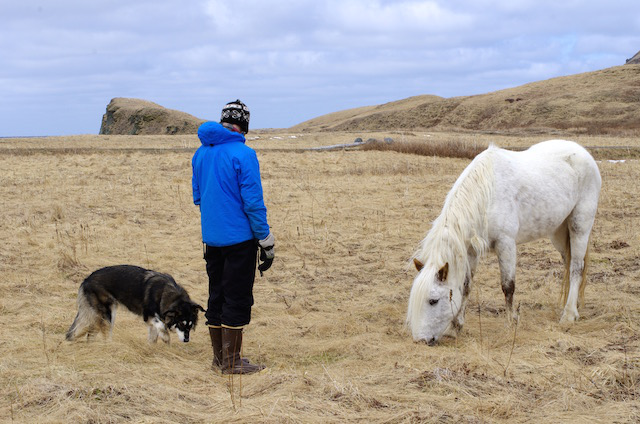

In [ ]:
from PIL import Image
Image.open('darknet/data/person.jpg')

In [ ]:
! cd darknet; ./darknet detect /content/darknet/cfg/yolov4.cfg  /content/yolov4.weights /content/darknet/data/person.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv     64       1 x 1/ 1    304 x

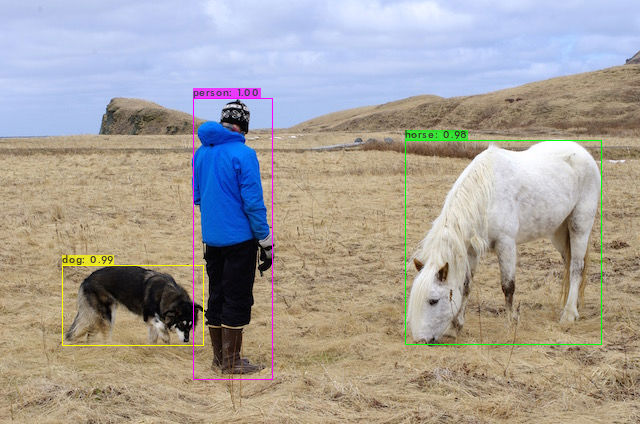

In [ ]:
from PIL import Image
Image.open('/content/darknet/predictions.jpg')


### 2.模型轉成ONNX

## DarkNet to ONNX

ref:https://github.com/Tianxiaomo/pytorch-YOLOv4/blob/master/demo_darknet2onnx.py 

In [ ]:

! sudo apt-get install protobuf-compiler libprotoc-dev
! pip install onnx==1.4.1
! git clone https://github.com/F64081169/tool.git
! pip install onnxruntime

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following additional packages will be installed:
  libprotobuf-dev libprotobuf-lite10
The following NEW packages will be installed:
  libprotobuf-dev libprotobuf-lite10 libprotoc-dev
0 upgraded, 3 newly installed, 0 to remove and 39 not upgraded.
Need to get 1,738 kB of archives.
After this operation, 13.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf-lite10 amd64 3.0.0-9.1ubuntu1 [97.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotobuf-dev amd64 3.0.0-9.1ubuntu1 [959 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/main amd64 libprotoc-dev amd64 3.0.0-9.1ubuntu1 [682 kB]
Fetched 1,738 kB in 1s (1,386 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend

Cloning into 'tool'...
remote: Enumerating objects: 23, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 23 (delta 1), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (23/23), done.
     |████████████████████████████████| 4.9 MB 5.6 MB/s 


In [ ]:
import sys
import onnx
import os
import argparse
import numpy as np
import cv2
import onnxruntime

from tool.utils import *
from tool.darknet2onnx import *


def main(cfg_file, namesfile, weight_file, image_path, batch_size):

    if batch_size <= 0:
        onnx_path_demo = transform_to_onnx(cfg_file, weight_file, batch_size)
    else:
        # Transform to onnx as specified batch size
        transform_to_onnx(cfg_file, weight_file, batch_size)
        # Transform to onnx as demo
        onnx_path_demo = transform_to_onnx(cfg_file, weight_file, 1)

    session = onnxruntime.InferenceSession(onnx_path_demo)
    # session = onnx.load(onnx_path)
    print("The model expects input shape: ", session.get_inputs()[0].shape)

    image_src = cv2.imread(image_path)
    detect(session, image_src, namesfile)



def detect(session, image_src, namesfile):
    IN_IMAGE_H = session.get_inputs()[0].shape[2]
    IN_IMAGE_W = session.get_inputs()[0].shape[3]

    # Input
    resized = cv2.resize(image_src, (IN_IMAGE_W, IN_IMAGE_H), interpolation=cv2.INTER_LINEAR)
    img_in = cv2.cvtColor(resized, cv2.COLOR_BGR2RGB)
    img_in = np.transpose(img_in, (2, 0, 1)).astype(np.float32)
    img_in = np.expand_dims(img_in, axis=0)
    img_in /= 255.0
    print("Shape of the network input: ", img_in.shape)

    # Compute
    input_name = session.get_inputs()[0].name

    outputs = session.run(None, {input_name: img_in})

    boxes = post_processing(img_in, 0.4, 0.6, outputs)

    class_names = load_class_names(namesfile)
    plot_boxes_cv2(image_src, boxes[0], savename='predictions_onnx.jpg', class_names=class_names)



if __name__ == '__main__':
    print("Converting to onnx and running demo ...")
    #if len(sys.argv) == 6:
    cfg_file = "/content/darknet/cfg/yolov4.cfg"#sys.argv[1]
    namesfile = "/content/darknet/data/coco.names"#sys.argv[2]
    weight_file = "/content/yolov4.weights"#sys.argv[3]
    image_path = "/content/darknet/predictions.jpg"#sys.argv[4]
    batch_size = 1#int(sys.argv[5])
    main(cfg_file, namesfile, weight_file, image_path, batch_size)
    #else:
        #print('Please run this way:\n')
        #print('  python demo_onnx.py <cfgFile> <namesFile> <weightFile> <imageFile> <batchSize>')

Converting to onnx and running demo ...
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64
    2 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    5 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32
    6 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   304 x 304 x 128   ->   304 x 304 x  64
   11 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128
   12 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   13 route  11
   14 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   15 conv     64  1 x 1 / 1   152 x 152 x  64   ->   152 

/content/tool/yolo_layer.py:227: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  bx = bxy[:, ii : ii + 1] + torch.tensor(grid_x, device=device, dtype=torch.float32) # grid_x.to(device=device, dtype=torch.float32)
/content/tool/yolo_layer.py:229: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  by = bxy[:, ii + 1 : ii + 2] + torch.tensor(grid_y, device=device, dtype=torch.float32) # grid_y.to(device=device, dtype=torch.float32)


Onnx model exporting done
layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64
    2 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    3 route  1
    4 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    5 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32
    6 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64
    7 shortcut 4
    8 conv     64  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  64
    9 route  8 2
   10 conv     64  1 x 1 / 1   304 x 304 x 128   ->   304 x 304 x  64
   11 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128
   12 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   13 route  11
   14 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64
   15 conv     64  1 x 1 / 1   152 x 152 x  64   ->   152 x 152 x  64
  

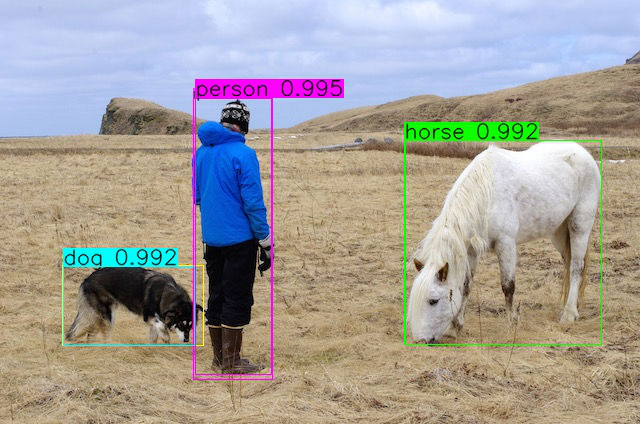

In [ ]:
Image.open('/content/predictions_onnx.jpg')

### 3.ONNX to tensorRT

剛剛那一步會將model .weight轉成.ONNX(yolov4_1_3_608_608_static.onnx)

接下來要將model 轉成tensorRT進行加速


In [ ]:
!nvcc --version
!cat /etc/issue


nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Ubuntu 18.04.5 LTS \n \l



In [ ]:
!pip install -U --no-cache-dir gdown --pre
!gdown --id '1cidBidFJ_72IoQuO2Jml_G9YM6uA8qD1' --output nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007_1-1_amd64.deb

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.4.0-py3-none-any.whl size=14774 sha256=fa8047886fedb6ada73c0aac0e854db1f366f1bf40a1dbeb67112b69a6514c6d
  Stored in directory: /tmp/pip-ephem-wheel-cache-o6a67516/wheels/fb/c3/0e/c4d8ff8bfcb0461afff199471449f642179b74968c15b7a69c
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.2
    Uninstalling gdown-4.2.2:
      Successfully uninstalled gdown-4.2.2


/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1cidBidFJ_72IoQuO2Jml_G9YM6uA8qD1
To: /content/nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007_1-1_amd64.deb
100% 1.62G/1.62G [00:24<00:00, 66.2MB/s]


In [42]:
!dpkg -i nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007_1-1_amd64.deb
!apt-key add /var/nv-tensorrt-repo-cuda11.1-trt7.2.1.6-ga-20201007/7fa2af80.pub
!apt-get update
!apt-get install -y --no-install-recommends libnvinfer7=7.2.1-1+cuda11.1
!apt-get install -y --no-install-recommends libnvinfer-dev=7.2.1-1+cuda11.1
!apt-get install tensorrt
!apt-get install python3-libnvinfer-dev
!apt-get install uff-converter-tf

(Reading database ... 155704 files and directories currently installed.)
Preparing to unpack nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007_1-1_amd64.deb ...
Unpacking nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007 (1-1) over (1-1) ...
Setting up nv-tensorrt-repo-ubuntu1804-cuda11.1-trt7.2.1.6-ga-20201007 (1-1) ...
OK
Get:1 file:/var/nv-tensorrt-repo-cuda11.1-trt7.2.1.6-ga-20201007  InRelease
Ign:1 file:/var/nv-tensorrt-repo-cuda11.1-trt7.2.1.6-ga-20201007  InRelease
Get:2 file:/var/nv-tensorrt-repo-cuda11.1-trt7.2.1.6-ga-20201007  Release [574 B]
Get:2 file:/var/nv-tensorrt-repo-cuda11.1-trt7.2.1.6-ga-20201007  Release [574 B]
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease


In [43]:
!dpkg -l | grep TensorRT

ii  graphsurgeon-tf                                             7.2.1-1+cuda11.1                    amd64        GraphSurgeon for TensorRT package
ii  libnvinfer-dev                                              8.2.3-1+cuda11.4                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev                                       8.2.3-1+cuda11.4                    amd64        TensorRT plugin libraries
ii  libnvinfer-plugin8                                          8.2.3-1+cuda11.4                    amd64        TensorRT plugin libraries
ii  libnvinfer7                                                 7.2.1-1+cuda11.1                    amd64        TensorRT runtime libraries
ii  libnvinfer8                                                 8.2.3-1+cuda11.4                    amd64        TensorRT runtime libraries
ii  libnvonnxparsers-dev                                        8.2.3-1+cuda11.4                    amd64        TensorRT ONNX libraries
ii